Importing all the necessary libraries:

In [66]:
# Importing everything for SQL addressing:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Importing libraries for data treatment:
import numpy as np
import pandas as pd

# Treating missing data
import missingno as msno
# Plotting...
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import altair as alt

# Set 3 decimal digit output for the pd float
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Get env variables.
load_dotenv()


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)


Connecting to DB and retrieving data into the CSV files ```./data/king_county_house_sales.csv``` and ```./data/king_county_house_details.csv```

In [67]:
DB_STRING = os.getenv('DB_STRING')
db = create_engine(DB_STRING)
query_string = "SELECT * FROM eda.king_county_house_sales"
query_string_2 = "SELECT * FROM eda.king_county_house_details"
query_string_3 = "SELECT * FROM eda.king_county_house_sales INNER JOIN eda.king_county_house_details ON eda.king_county_house_sales.house_id = eda.king_county_house_details.id;"

# Retrieving table 1
df_sqlalchemy = pd.read_sql(query_string, db)
df_sqlalchemy.to_csv('./data/king_county_house_sales.csv',index=False)

# Retrieving table 2
df_sqlalchemy = pd.read_sql(query_string_2, db)
df_sqlalchemy.to_csv('./data/king_county_house_details.csv',index=False)

# Retrieving joinet table
df_sqlalchemy = pd.read_sql(query_string_3, db)
df_sqlalchemy = df_sqlalchemy.loc[:, df_sqlalchemy.columns.duplicated() == False].copy() # Same as df_sqlalchemy = df_sqlalchemy.loc[:, ~df_sqlalchemy.columns.duplicated()].copy()
df_sqlalchemy.to_csv('./data/king_county_house_joined.csv',index=False)


#Cleaning up space
del DB_STRING, db, query_string,query_string_2, query_string_3,df_sqlalchemy

Reading throug sales survey data and inspecting it..

In [68]:
df_sales = pd.read_csv('./data/king_county_house_sales.csv')
df_sales.info()
print('\n')
[print(f"{item} column has {df_sales[item].nunique()} unique values.")  for item in df_sales.columns.tolist()]

print(f'Table SALES has following duplicates: {df_sales.duplicated().value_counts()} \n')

for item in df_sales.columns.tolist():
    if df_sales[item].nunique() < 20:
        print(f"{item} column has {df_sales[item].unique()} unique values.")



del df_sales

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      21597 non-null  object 
 1   price     21597 non-null  float64
 2   house_id  21597 non-null  int64  
 3   id        21597 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 675.0+ KB


date column has 372 unique values.
price column has 3622 unique values.
house_id column has 21420 unique values.
id column has 21597 unique values.
Table SALES has following duplicates: False    21597
Name: count, dtype: int64 



Reading throug details data and inspecting it..

In [69]:
df_details = pd.read_csv('./data/king_county_house_details.csv')
df_details.info()
print('\n')
[print(f"{item} column has {df_details[item].nunique()} unique values.")  for item in df_details.columns.tolist()]
print('\n')

print(f'Table DETAILS has following columns:\n {df_details.columns.tolist()} \n')
print(f'Table DETAILS contains duplicates:\n{df_details.duplicated().value_counts()}\n')


for item in df_details.columns.tolist():
    if df_details[item].nunique() < 20:
        print(f"{item} column has {df_details[item].unique()} unique values.")



del df_details

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21420 entries, 0 to 21419
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21420 non-null  int64  
 1   bedrooms       21420 non-null  float64
 2   bathrooms      21420 non-null  float64
 3   sqft_living    21420 non-null  float64
 4   sqft_lot       21420 non-null  float64
 5   floors         21420 non-null  float64
 6   waterfront     19060 non-null  float64
 7   view           21357 non-null  float64
 8   condition      21420 non-null  int64  
 9   grade          21420 non-null  int64  
 10  sqft_above     21420 non-null  float64
 11  sqft_basement  20969 non-null  float64
 12  yr_built       21420 non-null  int64  
 13  yr_renovated   17609 non-null  float64
 14  zipcode        21420 non-null  int64  
 15  lat            21420 non-null  float64
 16  long           21420 non-null  float64
 17  sqft_living15  21420 non-null  float64
 18  sqft_l

And now - merged one. Formatting, adding new columns, renaming, etc.

In [70]:
df = pd.read_csv('./data/king_county_house_joined.csv')

print('\n')
[print(f"{item} column has {df[item].nunique()} unique values.")  for item in df.columns.tolist()]
print('\n')

print(f'Table DETAILS has following columns:\n {df.columns.tolist()} \n')
print(f'Table DETAILS contains duplicates:\n{df.duplicated().value_counts()}\n')


for item in df.columns.tolist():
    if df[item].nunique() < 20:
        print(f"{item} column has {df[item].unique()} unique values.")

df['sqft_living_per_usd'] = df['sqft_living']/df['price']
df['sqft_lot_per_usd'] = df['sqft_lot']/df['price']
df['price'] = df['price']/1000
df = df.rename({'price':'price_t'},axis=1)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')


def year_trim(val):
    if val > 2100:
        return(val/10)
    else:
        return(val)

df['yr_renovated'] = df['yr_renovated'].apply(lambda x: year_trim(x))
df['view'] = df['view'].fillna(-1)
df['waterfront'] = df['waterfront'].fillna(-1)






date column has 372 unique values.
price column has 3622 unique values.
house_id column has 21420 unique values.
id column has 21597 unique values.
bedrooms column has 12 unique values.
bathrooms column has 29 unique values.
sqft_living column has 1034 unique values.
sqft_lot column has 9776 unique values.
floors column has 6 unique values.
waterfront column has 2 unique values.
view column has 5 unique values.
condition column has 5 unique values.
grade column has 11 unique values.
sqft_above column has 942 unique values.
sqft_basement column has 303 unique values.
yr_built column has 116 unique values.
yr_renovated column has 70 unique values.
zipcode column has 70 unique values.
lat column has 5033 unique values.
long column has 752 unique values.
sqft_living15 column has 777 unique values.
sqft_lot15 column has 8682 unique values.


Table DETAILS has following columns:
 ['date', 'price', 'house_id', 'id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront',

Categorizing some columns:

In [71]:
def bins_gen(min=0,max=100,step=10):
    min = int(min)
    if min < 0:
        ret=[0]
        ret.append(min)
    else:
        ret=[min]
    while min <= int(max):
        min += int(step)
        ret.append(min)
    return(ret)

def trim_cats(val):
    val = int(val.replace('(','').replace(')','').replace('[','').replace(']','').replace(' ','').split(',')[0])
    return(val)
print(df['price_t'].info())

bins_price = bins_gen(0, df['price_t'].max(), 10)
df['price_t_cat_from'] = pd.cut(df['price_t'], bins=bins_price, right=False).astype(str).apply(lambda x: trim_cats(x)).astype(int)

bins_sqft_living = bins_gen(0, df['sqft_living'].max(), 200)
df['sqft_living_cat_from'] = pd.cut(df['sqft_living'], bins=bins_sqft_living, right=False).astype(str).apply(lambda x: trim_cats(x)).astype(int)






del bins_price, bins_sqft_living

<class 'pandas.core.series.Series'>
RangeIndex: 21597 entries, 0 to 21596
Series name: price_t
Non-Null Count  Dtype  
--------------  -----  
21597 non-null  float64
dtypes: float64(1)
memory usage: 168.9 KB
None


Now - deep dive into the data:

Index(['date', 'price_t', 'house_id', 'id', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'sqft_living_per_usd', 'sqft_lot_per_usd', 'price_t_cat_from',
       'sqft_living_cat_from'],
      dtype='object')
['98178' '98125' '98028' '98136' '98074' '98053' '98003' '98198' '98146'
 '98038' '98007' '98115' '98107' '98126' '98019' '98103' '98002' '98133'
 '98040' '98092' '98030' '98119' '98112' '98052' '98027' '98117' '98058'
 '98001' '98056' '98166' '98023' '98070' '98148' '98105' '98042' '98008'
 '98059' '98122' '98144' '98004' '98005' '98034' '98075' '98116' '98010'
 '98118' '98199' '98032' '98045' '98102' '98077' '98108' '98168' '98177'
 '98065' '98029' '98006' '98109' '98022' '98033' '98155' '98024' '98011'
 '98031' '98106' '98072' '98188' '98014' '98055' '98039']


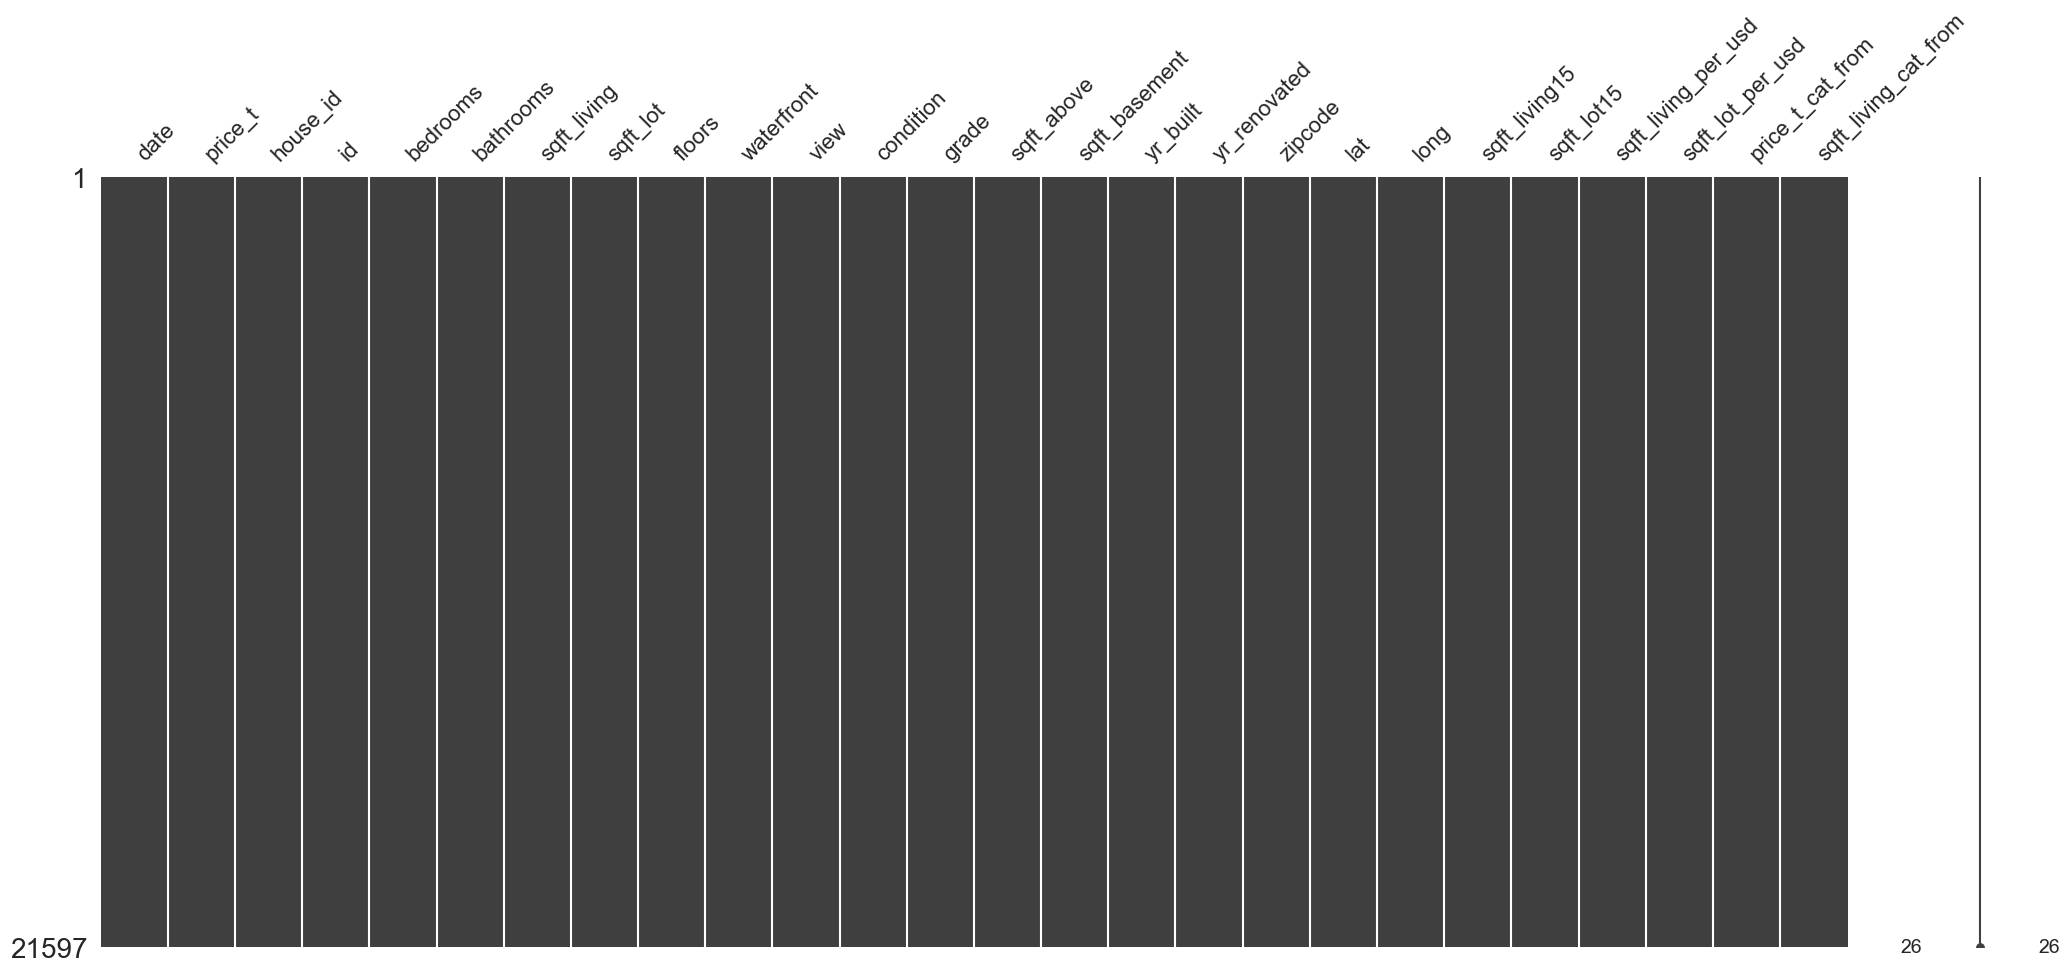

In [72]:
print(df.columns)
df['zipcode'] = df['zipcode'].astype(str)

df[['yr_renovated', 'sqft_basement']] = df[['yr_renovated', 'sqft_basement']].fillna(0)
df[['view', 'waterfront']] = df[['view', 'waterfront']].fillna(-1)


df.query('view > 0')

msno.matrix(df)
print(df['zipcode'].unique())

Lets look at the correlations of the whole dataset. INITIAL OBSERVATIONS

In [73]:
df.corr(method='spearman', min_periods=1, numeric_only=False).style.background_gradient(cmap='coolwarm')

Lot area does not correlate to the price (scatter confirmation):

In [74]:
scatter_df = df[(df['sqft_lot'] < df['sqft_lot'].quantile(q=0.95)) & (df['price_t'] < df['price_t'].quantile(q=0.95)) ]

fig_plotly = px.scatter(
    data_frame = scatter_df,
    x='sqft_lot',
    y='price_t',
     labels={'sqft_lot': 'Lot area, sqft',
            'price_t': 'Price, tUSD'}
)

fig_plotly.show()

... unlike living area:

In [75]:
scatter_df = df[(df['sqft_lot'] < df['sqft_lot'].quantile(q=0.95)) & (df['price_t'] < df['price_t'].quantile(q=0.95)) ]
fig_plotly = px.scatter(
    data_frame = scatter_df,
    x='sqft_living',
    y='price_t',
    labels={'sqft_lot': 'Lliving area, sqft',
            'price_t': 'Price, tUSD'}
)

fig_plotly.show()

In [76]:
bar_df_group = df[(df['sqft_lot'] < df['sqft_lot'].quantile(q=0.95)) &
            (df['price_t'] < df['price_t'].quantile(q=0.95)) &
            ( df['price_t'] < df['price_t'].median()*0.5)].groupby('price_t_cat_from')
bar_df = bar_df_group[['sqft_living', 'sqft_lot', 'grade']].mean().reset_index()



fig_plotly = px.bar(
     data_frame = bar_df,
     x=bar_df['price_t_cat_from'],
     y=bar_df['sqft_living'],
     color=bar_df['grade'],
     width=800,
     height=400,
     labels={'price_t_cat_from': 'Price from, tUSD','sqft_living': 'Mean living area, sqft'}
)

fig_plotly.update_layout(title_text = 'Mean <b>LIVING</b> area vs price paid',
                    showlegend = False,
                    title_x=0.5,
                    title_y=1,
                    coloraxis_colorbar_title_text = 'Grade',
                    font=dict(size=14),
                    margin = {'l' : 0, 'r' : 0, 'b' : 20, 't': 20}
)

fig_plotly.show()

del bar_df, bar_df_group


In [77]:
bar_df_group = df[(df['sqft_lot'] < df['sqft_lot'].quantile(q=0.95)) &
            (df['price_t'] < df['price_t'].quantile(q=0.95)) &
            ( df['price_t'] < df['price_t'].median()*0.5)].groupby('price_t_cat_from')



bar_df = bar_df_group[['sqft_living', 'sqft_lot', 'grade']].mean().reset_index()
fig_plotly = px.bar(
     data_frame = bar_df,
     x=bar_df['price_t_cat_from'],
     y=bar_df['sqft_lot'],
     color=bar_df['grade'],
     width=800,
     height=400,
     labels={'price_t_cat_from': 'Price from, tUSD','sqft_lot': 'Mean lot area, sqft'}
)

fig_plotly.update_layout(title_text = 'Mean <b>LOT</b> area vs price paid',
                    showlegend = False,
                    title_x=0.5,
                    title_y=1,
                    coloraxis_colorbar_title_text = 'Grade',
                    font=dict(size=14),
                    margin = {'l' : 0, 'r' : 0, 'b' : 20, 't': 20}
)
fig_plotly.show()


del bar_df_group, bar_df

I'll check this ploting the maps:

In [78]:
geodata = df #[( df['sqft_lot_per_usd'] > df['sqft_lot_per_usd'].median())  ]   # & (df['price_t'] < df['price_t'].median()) & (df['house_id'].duplicated())


geo = px.scatter_mapbox(df,
                    lon = geodata['long'],
                    lat = geodata['lat'],
                    zoom = 9.2,
                    color = geodata['price_t'],
                    size = geodata['sqft_living_per_usd'],
                    size_max = 25,
                    width = 1200,
                    height = 800,
                    title = 'King County houses'
)
geo.update_layout(title_text = '<b>Price and living area of the property</b>',
                    showlegend = True,
                    mapbox_style="open-street-map",
                    title_x=0.5,
                    title_y=1,
                    width=1000,
                    height=800,
                    coloraxis_colorbar_title_text = 'Price, tUSD',
                    font=dict(size=18),
                    margin = {'l' : 0, 'r' : 0, 'b' : 20, 't': 20}
)






geo.update_layout(coloraxis=dict(cmax=geodata['price_t'].quantile(0.95), cmin=geodata['price_t'].min()))


#del geodata

At the same time ...

In [79]:
geodata = df #[( df['sqft_lot_per_usd'] > df['sqft_lot_per_usd'].median())  ]   # & (df['price_t'] < df['price_t'].median()) & (df['house_id'].duplicated())



geo = px.scatter_mapbox(df,
                    lon = geodata['long'],
                    lat = geodata['lat'],
                    zoom = 9.2,
                    color = geodata['sqft_living_per_usd'],
                    size = geodata['price_t'],
                    size_max = 30,
                    width = 1200,
                    height = 800,
                    title = 'King County houses'
)
geo.update_layout(title_text = '<b>Price (total) and area per $ of the property</b>',
                    showlegend = True,
                    mapbox_style="open-street-map",
                    title_x=0.5,
                    title_y=1,
                    width=1000,
                    height=800,
                    coloraxis_colorbar_title_text = 'sqft (living) per USD',
                    font=dict(size=18),
                    margin = {'l' : 0, 'r' : 0, 'b' : 20, 't': 20}
)


geo.update_layout(coloraxis=dict(cmax=geodata['sqft_living_per_usd'].quantile(0.95), cmin=geodata['sqft_living_per_usd'].min()))


**Poor neighbourhood = house price < median for the county:**

In [80]:
geodata = df[( df['price_t'] < df['price_t'].median()*0.5)  ]




geo = px.scatter_mapbox(df,
                    lon = geodata['long'],
                    lat = geodata['lat'],
                    zoom = 9.2,
                    color = geodata['price_t'],
                    size = geodata['sqft_living'],
                    size_max = 20,
                    width = 1000,
                    height = 600,
                    title = 'King County houses'
)
geo.update_layout(title_text = '<b>Price (total) and living area</b>',
                    showlegend = True,
                    mapbox_style="open-street-map",
                    title_x=0.5,
                    title_y=0.99,
                    coloraxis_colorbar_title_text = 'Living area, sqft',
                    font=dict(size=16),
                    margin = {'l' : 0, 'r' : 0, 'b' : 0, 't': 30}
)

geo.update_layout(coloraxis=dict(cmax=geodata['price_t'].quantile(0.95), cmin=geodata['price_t'].min()))

HERE IS THE NARROW DATASET DEFINITION - **half of median price**:

In [81]:
pdf = df[ ( df['price_t'] < df['price_t'].median()*0.5) ]   # & (df['price_t'] < df['price_t'].median()) & (df['house_id'].duplicated())

Lets see the Spearman correlation matrix of the narrow dataset:

In [82]:
#SERVICE FIELD:
pdf.corr(method='spearman', min_periods=1, numeric_only=False).style.background_gradient(cmap='coolwarm')

**The condition of the houses increases alongside the longitude (i.e. the more far the property from the shore, the better the condition):**

In [83]:

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Low price property', 'All data'))



plot_1 = go.Box(
    x=pdf['condition'],
    y=pdf['long'],
    name = '<b>Low price property</b>',
    line=dict(color='rgba(0,0,0,1)'),
    fillcolor='rgba(255,140,0,0.8)'
)


plot_2 = go.Box(
    x=df['condition'],
    y=df['long'],
    name = '<b>All data</b>',
    line=dict(color='rgba(0,0,0,1)'),
    fillcolor='rgba(0,191,255,0.8)'
)

fig.update_layout(title = '<b>Condition-longitude correlation</b>',
                    showlegend = False,
                    title_x=0.5,
                    title_y=1,
                    width = 1000,
                    height = 700,
                    font=dict(size=20),
                    margin = {'l' : 0, 'r' : 0, 'b' : 0, 't': 50}
)

fig.append_trace(plot_1, 1, 1)
fig.append_trace(plot_2, 1, 2)

fig.update_xaxes(title='Condition',row=1,col=1)
fig.update_xaxes(title='Condition',row=1,col=2)

fig.update_yaxes(title='Longitude',row=1,col=1)

fig.show()


Let's inspect condition - grade correlation:

In [84]:
fig_plotly = px.box(data_frame=pdf,
    x=pdf['grade'],
    y=pdf['condition'],
    width=1000,
    height=700,
    labels={'grade': 'Grade', 'condition': 'Condition'}
#    size_max = 50
)
#fig_plotly.update_layout(coloraxis=dict(cmax=pdf['condition'].quantile(0.95), cmin=pdf['condition'].min()),
#    coloraxis_colorbar_title_text = 'price_t')
fig_plotly.update_layout(title_text = '<b>Condition-grade correlation</b>',
                    showlegend = True,
                    title_x=0.5,
                    title_y=1,
#                    width = 1000,
#                    height = 700,
                    font=dict(size=20),
                    margin = {'l' : 0, 'r' : 0, 'b' : 0, 't': 50}
)
fig_plotly.show()






Let's inspect how price correlates with different categories: 

In [85]:
pdf.yr_renovated[pdf.yr_renovated > 84].shape

(26,)

In [86]:

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Renovated', 'Non-renovated'))



plot_1 = go.Box(
    x=pdf[pdf.yr_renovated > 1984]['sqft_living_cat_from'],
    y=pdf[pdf.yr_renovated > 1984]['price_t'],
    name = '<b></b>',
    line=dict(color='rgba(0,0,0,1)'),
    fillcolor='rgba(255,140,0,0.8)'
)


plot_2 = go.Box(
    x=pdf[pdf.yr_renovated < 1984]['sqft_living_cat_from'],
    y=pdf[pdf.yr_renovated < 1984]['price_t'],
    name = '<b>112132</b>',
    line=dict(color='rgba(0,0,0,1)'),
    fillcolor='rgba(0,191,255,0.8)',
)

fig.update_layout(title = '<b>Renovated vs non-renovated (narrowed)</b>',
                    showlegend = False,
                    title_x=0.5,
                    title_y=1,
                    width = 1600,
                    height = 500,
                    font=dict(size=20),
                    margin = {'l' : 0, 'r' : 0, 'b' : 0, 't': 50}
)
#fig['layout']['xaxis']['title']='Living area from, sqft'
#fig['layout']['xaxis2']['title']='Living area from, sqft'
#fig['layout']['yaxis']['title']='Label y-axis 1'
#fig['layout']['yaxis2']['title']=''

fig.append_trace(plot_1, 1, 1)
fig.append_trace(plot_2, 1, 2)
fig.update_xaxes(range=[pdf[pdf.yr_renovated < 1984]['sqft_living_cat_from'].min()-100, pdf[pdf.yr_renovated < 1984]['sqft_living_cat_from'].max()+100],
                    title='Living area from, sqft',row=1,col=1)
fig.update_xaxes(range=[pdf[pdf.yr_renovated < 1984]['sqft_living_cat_from'].min()-100, pdf[pdf.yr_renovated < 1984]['sqft_living_cat_from'].max()+100],
                    title='Living area from, sqft',row=1,col=2)
fig.update_yaxes(title='Price, tUSD',row=1,col=1)
fig.update_yaxes(title='Price, tUSD',row=1,col=2)

fig.show()

Apparently, for narrowed dataset the data is non-conclusive. Let's see whether this is true for all dataset:

In [87]:

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Renovated', 'Non-renovated'))



plot_1 = go.Box(
    x=df[df.yr_renovated > 1984]['sqft_living_cat_from'],
    y=df[df.yr_renovated > 1984]['price_t'],
    name = '<b></b>',
    line=dict(color='rgba(0,0,0,1)'),
    fillcolor='rgba(255,140,0,0.8)'
)


plot_2 = go.Box(
    x=df[df.yr_renovated < 1984]['sqft_living_cat_from'],
    y=df[df.yr_renovated < 1984]['price_t'],
    name = '<b>112132</b>',
    line=dict(color='rgba(0,0,0,1)'),
    fillcolor='rgba(0,191,255,0.8)',
)

fig.update_layout(title = '<b>Renovated vs non-renovated (all data)</b>',
                    showlegend = False,
                    title_x=0.5,
                    title_y=1,
                    width = 1600,
                    height = 500,
                    font=dict(size=20),
                    margin = {'l' : 0, 'r' : 0, 'b' : 0, 't': 50}
)
#fig['layout']['xaxis']['title']='Living area from, sqft'
#fig['layout']['xaxis2']['title']='Living area from, sqft'
#fig['layout']['yaxis']['title']='Label y-axis 1'
#fig['layout']['yaxis2']['title']=''

fig.append_trace(plot_1, 1, 1)
fig.append_trace(plot_2, 1, 2)

fig.update_xaxes(range=[df[df.yr_renovated < 1984]['sqft_living_cat_from'].min()-100, df[df.yr_renovated < 1984]['sqft_living_cat_from'].quantile(0.95)+100],
                    title='Living area from, sqft',row=1,col=1)
fig.update_xaxes(range=[df[df.yr_renovated < 1984]['sqft_living_cat_from'].min()-100, df[df.yr_renovated < 1984]['sqft_living_cat_from'].quantile(0.95)+100],
                    title='Living area from, sqft',row=1,col=2)

fig.update_yaxes(range=[df[df.yr_renovated < 1984]['price_t'].min()-100, df[df.yr_renovated < 1984]['price_t'].quantile(0.99)+100],
                    title='Price, tUSD',row=1,col=1)
fig.update_yaxes(range=[df[df.yr_renovated < 1984]['price_t'].min()-100, df[df.yr_renovated < 1984]['price_t'].quantile(0.99)+100],
                    title='Price, tUSD',row=1,col=2)

fig.show()

Let's see if we have any **seasonality** (and, perhaps, basement):

In [88]:
#pdf.groupby('sqft_basement').count()
#pdf['sqft_basement'].unique()
#pdf.columns
#print(px.colors.qualitative.Alphabet)

In [89]:

fig_plotly = px.scatter(#data_frame=pdf,
    x=pdf['date'],
    y=pdf['price_t'],
    color=pdf['condition'],
    size=pdf['sqft_living'],
#    color_discrete_sequence=px.colors.qualitative.Alphabet,    # discrete color sequence simply doesn't work
    color_continuous_scale=px.colors.sequential.Rainbow,
    width = 1200,
    height = 800,
    marginal_x="histogram"
)


fig_plotly.update_layout(title_text = 'Property offers seasonality (lower price range)',
#                    scattermode="group",
#                    showlegend = True,
                    title_x=0.5,
                    title_y=1,
                    coloraxis_colorbar_title_text = 'condition',
                    font=dict(size=14),
                    margin = {'l' : 0, 'r' : 0, 'b' : 20, 't': 20}
)

fig_plotly.update_xaxes(title='Date')
fig_plotly.update_yaxes(title='Price, tUSD')

fig_plotly['layout']['yaxis2']['title']='Counts'

fig_plotly.show()

Let's compare median living area for prices below 150 and above:

In [ ]:
print(pdf[pdf['price_t'] <=150 ]['sqft_living'].median())
print(pdf[pdf['price_t'] <=150 ]['price_t'].median())
print(pdf[pdf['price_t'] >150 ]['sqft_living'].median())
print(pdf[pdf['price_t'] >150 ]['price_t'].median())


910.0
130.0
1180.0
200.0


Insight for the client 1: great condition (5)

In [137]:
#Service field:
ipdf_1 = pdf[(pdf['condition'] >=5) & (pdf['sqft_living'] >pdf['sqft_living'].median())].sort_values(['sqft_living_per_usd', 'sqft_lot_per_usd', 'grade' ], ascending=False).head(10).copy()
ipdf_1.columns
ipdf_1[['date', 'house_id', 'price_t', 'bedrooms', 'bathrooms', 'sqft_basement', 'sqft_living', 'sqft_lot', 'condition', 'grade', 'yr_built', 'yr_renovated']]

date    house_id  price_t  bedrooms  bathrooms  sqft_basement  \
17183 2014-05-12  5111400086  110.000     3.000      1.000          0.000   
10200 2014-06-20  1921059235  215.000     4.000      2.500        980.000   
17052 2015-02-18  8651402750  132.825     3.000      1.500          0.000   
11407 2014-05-28  7116500125  189.000     2.000      2.000        850.000   
19355 2015-02-16  3353401340  199.900     4.000      1.750          0.000   
1795  2015-02-23   185000118  212.000     4.000      2.000        900.000   
8521  2014-07-09  8005100540  215.000     4.000      1.500          0.000   
16724 2015-03-25  3977630130  146.300     3.000      1.000          0.000   
15994 2014-10-17   321049193  215.000     3.000      2.000        660.000   
3523  2014-09-19  8005100025  195.000     3.000      1.000          0.000   

       sqft_living  sqft_lot  condition  grade  yr_built  yr_renovated  
17183     1250.000 53143.000          5      6      1945         0.000  
10200     1960.000 11600.000          5      6      1931         0.000  
17052     1210.000  5200.000          5      6      1969         0.000  
11407     1700.000  3171.000          5      5      1927         0.000  
19355     1790.000 12000.000          5      6      1944         0.000  
1795      1880.000  7500.000          5      6      1946         0.000  
8521      1860.000  5040.000          5      8      1920         0.000  
16724     1200.000  9668.000          5      6      1975         0.000  
15994     1760.000  9282.000          5      7      1947         0.000  
3523      1510.000  4350.000          5      6      1913         0.000

In [136]:
geo = px.scatter_mapbox(ipdf_1,
                    lon = ipdf_1['long'],
                    lat = ipdf_1['lat'],
                    zoom = 9.2,
                    color = ipdf_1['sqft_living_per_usd'],
                    size = ipdf_1['sqft_lot_per_usd'],
                    size_max = 45,
                    width = 1400,
                    height = 600,
                    color_continuous_scale=px.colors.sequential.Rainbow
#                    title = 'King County houses'
)
geo.update_layout(title_text = '<b>Top 10 properties with maximum living and lot areas, and grade  </b>',
                    showlegend = True,
                    mapbox_style="open-street-map",
                    title_x=0.5,
                    title_y=1,
#                    width=1000,
#                    height=800,
                    coloraxis_colorbar_title_text = 'Lot area price, <br> sqft/USD',
                    font=dict(size=18),
                    margin = {'l' : 0, 'r' : 0, 'b' : 20, 't': 30}
)






geo.update_layout(coloraxis=dict(cmax=ipdf_1['sqft_living_per_usd'].max(), cmin=ipdf_1['sqft_living_per_usd'].min()))

Now, I'd like to see correlation matrix for narrow data:

In [148]:
pdf_corr = pdf[['date', 'house_id', 'price_t', 'bedrooms', 'bathrooms', 'sqft_basement', 'sqft_living', 'sqft_lot', 'condition', 'grade', 'yr_built', 'yr_renovated']].corr(
    method='spearman', min_periods=1, numeric_only=False)
names = ['Date', 'House ID', 'Price', 'Bedrooms', 'Bathrooms', 'Basement area', 'Living area', 'Lot area', 'Condition', 'Grade', 'Built, yr', 'Renovation, yr']

matrx = go.Figure()
matrx.add_trace(go.Heatmap(
        x = names,
        y = names,
        z = np.array(pdf_corr),
        text=pdf_corr.values,
        texttemplate='%{text:.2f}'
    )
)

matrx.update_layout(title_text = '<b>Correlation map</b>',
                    showlegend = True,
                    title_x=0.5,
                    title_y=0.99,
                    width=1400,
                    height=450,
                    font=dict(size=16),
                    margin = {'l' : 0, 'r' : 0, 'b' : 20, 't': 30}
)
matrx.show()

In [93]:


fig_plotly = px.bar(
     data_frame = pdf,
     x=pdf['sqft_living_cat_from'],
     y=pdf['sqft_lot'],
     color=pdf['grade'],
     width=800,
     height=400,
     labels={'price_t_cat_from': 'Price from, tUSD','sqft_lot': 'Mean lot area, sqft'}
)

fig_plotly.update_layout(title_text = 'Mean <b>LOT</b> area vs price paid',
                    showlegend = False,
                    title_x=0.5,
                    title_y=1,
                    coloraxis_colorbar_title_text = 'Grade',
                    font=dict(size=14),
                    margin = {'l' : 0, 'r' : 0, 'b' : 20, 't': 20}
)
fig_plotly.show()

C:\Users\Dima\AppData\Local\Temp\ipykernel_39964\876458444.py:9: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Dima\AppData\Local\Temp\ipykernel_39964\876458444.py:9: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



[]

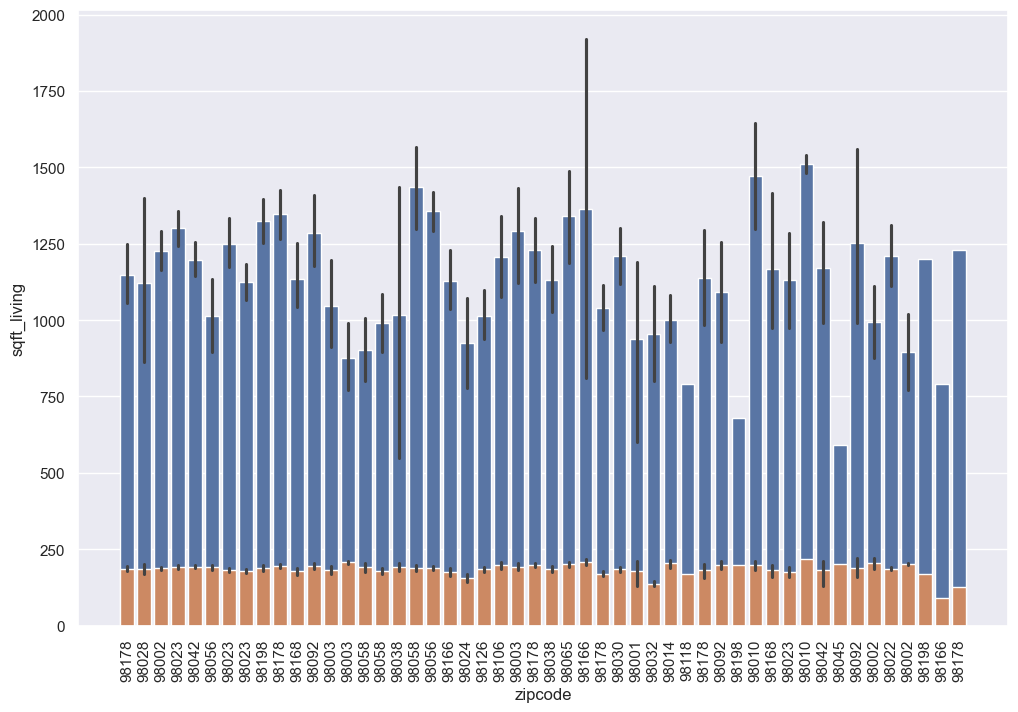

In [94]:
sns.set_theme(rc={'figure.figsize':(12,8)})

for it in ['sqft_living','price_t']:
    plt = sns.barplot(
        data = pdf,
        x = pdf['zipcode'],
        y = pdf[it],
    )
    plt.set_xticklabels(labels=pdf['zipcode'], rotation=90)
plt.plot()